In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shakespeare-plays/alllines.txt
/kaggle/input/shakespeare-plays/Shakespeare_data.csv
/kaggle/input/shakespeare-plays/william-shakespeare-black-silhouette.jpg


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils 
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/kaggle/input/shakespeare-plays/Shakespeare_data.csv')
df.head(5)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [4]:
import csv

corpus = []
with open('/kaggle/input/shakespeare-plays/Shakespeare_data.csv') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)        # to pass first row,header
    for row in reader:
        corpus.append(row[5])
        
print(len(corpus))
print(corpus[:3])

111396
['ACT I', 'SCENE I. London. The palace.', 'Enter KING HENRY, LORD JOHN OF LANCASTER, the EARL of WESTMORELAND, SIR WALTER BLUNT, and others']


In [5]:
import string

def text_cleaner(text):
    text = "".join(car for car in text if car not in string.punctuation).lower()
    text = text.encode("utf8").decode("ascii",'ignore')
    return text

corpus = [text_cleaner(line) for line in corpus]

In [6]:
# Tokenization is the process of splitting up a text into a list of individual words, or tokens.
# corpus is too big if you try with all data, you can see this message
corpus = corpus[:5000]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_words = len(word_index) + 1
total_words

5411

In [7]:
# create input sequences using list of tokens
input_sequences =[]

for sentence in corpus:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [8]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='pre'))

In [9]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
# create one-hot encoding of the labels
label = tensorflow.keras.utils.to_categorical(label, num_classes=total_words)

In [10]:
print(label[0])
print(label.shape)
print(predictors.shape)

[0. 0. 0. ... 0. 0. 0.]
(32802, 5411)
(32802, 33)


**Adding laeyrs to our model**

In [11]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(0.3))
#model.add(Dense(total_words, activation='softmax'))
#model.add(LSTM(128))
#model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#(None, 1024)

2022-05-02 05:33:54.440135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 05:33:54.543387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 05:33:54.544596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 05:33:54.546362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 10)            54110     
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2142208   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5411)              5546275   
Total params: 7,742,593
Trainable params: 7,742,593
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
 history = model.fit(predictors, label, epochs=50,  verbose=1)

2022-05-02 05:33:59.645606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-02 05:34:03.784483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1026/1026 [==============================] - 22s 17ms/step - loss: 6.9201 - accuracy: 0.0353
Epoch 2/50
1026/1026 [==============================] - 17s 16ms/step - loss: 6.5152 - accuracy: 0.0488
Epoch 3/50
1026/1026 [==============================] - 17s 16ms/step - loss: 6.3560 - accuracy: 0.0530
Epoch 4/50
1026/1026 [==============================] - 16s 16ms/step - loss: 6.2233 - accuracy: 0.0577
Epoch 5/50
1026/1026 [==============================] - 17s 17ms/step - loss: 6.0364 - accuracy: 0.0645
Epoch 6/50
1026/1026 [==============================] - 17s 16ms/step - loss: 5.8124 - accuracy: 0.0722
Epoch 7/50
1026/1026 [==============================] - 17s 16ms/step - loss: 5.5418 - accuracy: 0.0824
Epoch 8/50
1026/1026 [==============================] - 16s 16ms/step - loss: 5.2409 - accuracy: 0.0935
Epoch 9/50
1026/1026 [==============================] - 17s 17ms/step - loss: 4.8861 - accuracy: 0.1117
Epoch 10/50
1026/1026 [==============================] - 17s 16ms/step - lo

**Checking layer by layer model Output**

In [13]:
list_data = []
list_data.append(predictors[4:5])
list_data.append(predictors[8:9])
list_data.append(predictors[19:20])
encode_data=np.array(list_data)
#print(encode_data)
encode_docs = pad_sequences(encode_data,padding='pre',maxlen=33,truncating='post')
#encoded_state = pad_sequence()
print(encode_docs)

[[[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   4 301   1]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...  50  93  33]]

 [[  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  ...
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ... 380 322   2]]]


In [14]:
# first layer output converting words into embedding matrix
new_model = Sequential()
new_model.add(Embedding(total_words,5,input_length=max_sequence_len-1))
new_model.compile('adam','categorical_crossentropy')
new_model.summary()
output = new_model.predict(encode_data)
print(output.shape)
print(output[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 5)             27055     
Total params: 27,055
Trainable params: 27,055
Non-trainable params: 0
_________________________________________________________________
(3, 1, 33, 5)
[[[ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.

In [15]:
# second layer output of bidirectional Lstm
new_model1 = Sequential()
new_model1.add(Embedding(total_words,5,input_length=max_sequence_len-1))
new_model1.add(Bidirectional(LSTM(512)))
new_model1.compile('adam','categorical_crossentropy')
new_model1.summary()
#output = new_model1.predict(list_data)
#print(output.shape)
print(output[0])
print(new_model1.predict(predictors[22:30]))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 33, 5)             27055     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              2121728   
Total params: 2,148,783
Trainable params: 2,148,783
Non-trainable params: 0
_________________________________________________________________
[[[ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.02957339]
  [ 0.01785714  0.0294894  -0.01789104 -0.00384631  0.0295

Chanfing the loss function to check accuracy of new model

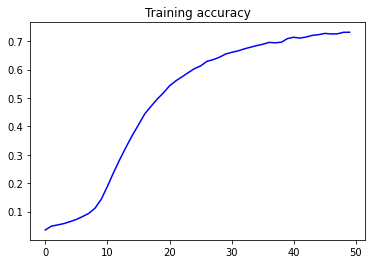

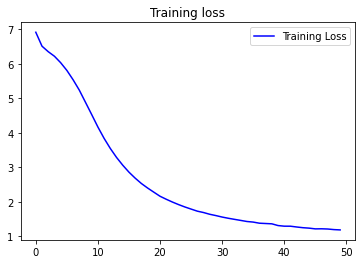

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

**Traing our model with other loss function to check its accuracy**

In [17]:
model1 = Sequential()
model1.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
model1.add(Bidirectional(LSTM(512)))
model1.add(Dropout(0.3))
#model.add(Dense(total_words, activation='softmax'))
#model.add(LSTM(128))
#model.add(Dropout(0.3))
model1.add(Dense(total_words, activation='softmax'))
model1.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
#(None, 1024)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 33, 10)            54110     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              2142208   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5411)              5546275   
Total params: 7,742,593
Trainable params: 7,742,593
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
history1 = model1.fit(predictors, label, epochs=50,  verbose=1)

Epoch 1/50
1026/1026 [==============================] - 20s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0202
Epoch 2/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 3/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 4/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 5/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 6/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 7/50
1026/1026 [==============================] - 16s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 8/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 9/50
1026/1026 [==============================] - 17s 16ms/step - loss: 1.8477e-04 - accuracy: 0.0355
Epoch 10/50
1026/1026 [=====

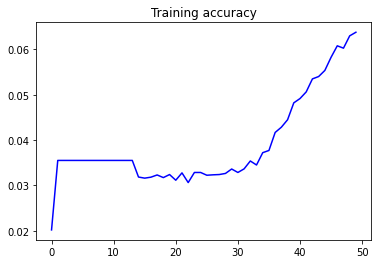

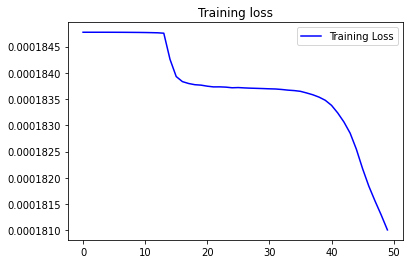

In [19]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
loss = history1.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [30]:
seed_text = "the soilder take away"
next_words = 4

  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predict_x= model.predict(token_list, verbose=0)
    predicted=np.argmax(predict_x,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    if len(seed_text) % 10 == 0 :
        seed_text+= '\n'
print(seed_text)

the soilder take away to be feared as


In [23]:
seed_text = "the PALACE lord is often"
next_words = 2

  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predict_x= model.predict(token_list, verbose=0)
    predicted=np.argmax(predict_x,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    if len(seed_text) % 10 == 0 :
        seed_text+= '\n'
print(seed_text)

the PALACE lord is often king of


In [24]:
seed_text = "Love all, trust a few"
next_words = 2

  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_classes(token_list, verbose=0)
    predict_x= model.predict(token_list, verbose=0)
    predicted=np.argmax(predict_x,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
    if len(seed_text) % 10 == 0 :
        seed_text+= '\n'
print(seed_text)

Love all, trust a few pluck a
